### 统计生命周期信息
绘制生命周期时间线图、内存访问图（以时间为X轴，内存地址空间为Y轴），统计运行总时间，计算实际活跃率

#### 1. 数据预处理

##### 1.1 读取数据

In [361]:
results_dir = "results"
page_size_byte = 4096

In [362]:
import pandas as pd
from sqlalchemy import create_engine

# 使用SQLAlchemy连接
engine = create_engine('sqlite:///data/xor/3_save_forward_fc.sqlite3')  # 注意路径格式：sqlite:///
df = pd.read_sql_table('trace', engine)
print(df.columns)
print(df.head())

Index(['ID', 'ParentID', 'Kind', 'What', 'Location', 'StartTime', 'EndTime',
       'DeviceID', 'PID', 'Address', 'ByteSize'],
      dtype='object')
              ID      ParentID     Kind                             What  \
0      1_req_out      1@Driver  req_out                 *mem.AllocateReq   
1      2_req_out      2@Driver  req_out                 *mem.AllocateReq   
2  15134_req_out  15134@Driver  req_out                 *mem.AllocateReq   
3  14825_req_out         14825  req_out  *protocol.MemoryAllocateTrigger   
4  15135_req_out         15135  req_out      *protocol.MemoryAllocateRsp   

                  Location  StartTime   EndTime  DeviceID  PID     Address  \
0                   Driver   0.000000  0.000000         1    1  4294971392   
1                   Driver   0.000000  0.000000         1    1  4294975488   
2                   Driver   0.000015  0.000015         1    1  4294979584   
3  GPU[1].CommandProcessor   0.000015  0.000015         0    0           0   
4   

In [363]:
# 向量化计算页范围
df['StartPage'] = df['Address'] // 4096
df['EndPage'] = (df['Address'] + df['ByteSize'] - 1) // 4096

# 筛选出内存相关的请求
mem_df = df[ df['What'].isin(['*mem.AllocateReq', '*mem.FreeReq']) | 
                df['What'].isin(['*mem.ReadReq', '*mem.WriteReq']) & 
                    ((df['Location'].str.contains('DRAM', na=False)) 
                    #  | (df['Location'].str.contains('L1', na=False)) 
                    #  | (df['Location'].str.contains('L2', na=False)) 
                    #  | (df['Location'].str.contains('DMA', na=False)) 
                    #  | (df['Kind'].str.contains('req_out') & (df['Location'].str.contains('AddrTrans', na=False)))
                    )
            ]

# print(mem_df[mem_df['What'].isin(['*mem.FreeReq'])])

# 生成所有页的访问记录
rows = []
for _, row in mem_df.iterrows():
    for page in range(row['StartPage'], row['EndPage'] + 1):
        rows.append({
            'DeviceID': row['DeviceID'],
            # 'PID': row['PID'],
            'PageID': page,
            'AccessType': row['What'],
            'StartTime': row['StartTime'],
            'EndTime': row['EndTime'],
        })

page_access_df = pd.DataFrame(rows)
print(page_access_df)
# print(page_access_df[page_access_df['AccessType'].isin(['*mem.FreeReq'])])


      DeviceID   PageID        AccessType  StartTime   EndTime
0            1  1048577  *mem.AllocateReq   0.000000  0.000000
1            1  1048578  *mem.AllocateReq   0.000000  0.000000
2            1  1048579  *mem.AllocateReq   0.000015  0.000015
3            0  1048579     *mem.WriteReq   0.000015  0.000015
4            0  1048579     *mem.WriteReq   0.000031  0.000031
...        ...      ...               ...        ...       ...
1397         0  1048712     *mem.WriteReq   0.003285  0.003285
1398         0  1048720     *mem.WriteReq   0.003285  0.003285
1399         0  1048712      *mem.ReadReq   0.003293  0.003293
1400         0  1048720      *mem.ReadReq   0.003303  0.003303
1401         0  1048580      *mem.ReadReq   0.003312  0.003312

[1402 rows x 5 columns]


##### 1.2 处理生命周期

In [364]:
import pandas as pd

# 假设数据在 page_access_df
page_access_df = page_access_df.sort_values(by=["PageID", "StartTime"]).reset_index(drop=True)

# 最大时间用于补全未释放生命周期
max_time = page_access_df["EndTime"].max()

lifecycles = []

# 遍历每个页面的访问序列
for page_id, group in page_access_df.groupby("PageID"):
    group = group.sort_values(by="StartTime")
    chunk = []
    in_lifecycle = False

    for _, row in group.iterrows():
        access_type = row["AccessType"]

        if "*mem.AllocateReq" in access_type:
            # 处理上一个未释放的生命周期
            if in_lifecycle and chunk:
                alloc_time = chunk[0]["StartTime"]
                free_time = max_time
                access_rows = [r for r in chunk if "*mem.ReadReq" in r["AccessType"] or "*mem.WriteReq" in r["AccessType"]]
                reads = [r for r in access_rows if "*mem.ReadReq" in r["AccessType"]]
                writes = [r for r in access_rows if "*mem.WriteReq" in r["AccessType"]]
                first_access = min([r["StartTime"] for r in access_rows], default=None)
                last_access = max([r["EndTime"] for r in access_rows], default=None)
                lifecycles.append({
                    "PageID": page_id,
                    "AllocateTime": alloc_time,
                    "FreeTime": free_time,
                    "LifeDuration": free_time - alloc_time,
                    "FirstAccessTime": first_access,
                    "LastAccessTime": last_access,
                    "RealLifeDuration": (last_access - alloc_time) if first_access is not None and last_access is not None else None,
                    "ReadCount": len(reads),
                    "WriteCount": len(writes),
                })
            # 新生命周期开始
            in_lifecycle = True
            chunk = [row]

        elif in_lifecycle:
            chunk.append(row)
            if "*mem.FreeReq" in access_type:
                alloc_time = chunk[0]["StartTime"]
                free_time = row["StartTime"]
                access_rows = [r for r in chunk if "*mem.ReadReq" in r["AccessType"] or "*mem.WriteReq" in r["AccessType"]]
                reads = [r for r in access_rows if "*mem.ReadReq" in r["AccessType"]]
                writes = [r for r in access_rows if "*mem.WriteReq" in r["AccessType"]]
                first_access = min([r["StartTime"] for r in access_rows], default=None)
                last_access = max([r["EndTime"] for r in access_rows], default=None)
                lifecycles.append({
                    "PageID": page_id,
                    "AllocateTime": alloc_time,
                    "FreeTime": free_time,
                    "LifeDuration": free_time - alloc_time,
                    "FirstAccessTime": first_access,
                    "LastAccessTime": last_access,
                    "RealLifeDuration": (last_access - alloc_time) if first_access is not None and last_access is not None else None,
                    "ReadCount": len(reads),
                    "WriteCount": len(writes),
                })
                chunk = []
                in_lifecycle = False

    # 收尾处理未释放生命周期
    if in_lifecycle and chunk:
        alloc_time = chunk[0]["StartTime"]
        free_time = max_time
        access_rows = [r for r in chunk if "*mem.ReadReq" in r["AccessType"] or "*mem.WriteReq" in r["AccessType"]]
        reads = [r for r in access_rows if "*mem.ReadReq" in r["AccessType"]]
        writes = [r for r in access_rows if "*mem.WriteReq" in r["AccessType"]]
        first_access = min([r["StartTime"] for r in access_rows], default=None)
        last_access = max([r["EndTime"] for r in access_rows], default=None)
        lifecycles.append({
            "PageID": page_id,
            "AllocateTime": alloc_time,
            "FreeTime": free_time,
            "LifeDuration": free_time - alloc_time,
            "FirstAccessTime": first_access,
            "LastAccessTime": last_access,
            "RealLifeDuration": (last_access - alloc_time) if first_access is not None and last_access is not None else None,
            "ReadCount": len(reads),
            "WriteCount": len(writes),
        })

# 转为 DataFrame
lifecycle_df = pd.DataFrame(lifecycles)

# 显示前几行
print(lifecycle_df.head())


    PageID  AllocateTime  FreeTime  LifeDuration  FirstAccessTime  \
0  1048577      0.000000  0.003312      0.003312         0.002203   
1  1048578      0.000000  0.003312      0.003312         0.001260   
2  1048579      0.000015  0.003312      0.003297         0.000015   
3  1048580      0.000046  0.003312      0.003266         0.000046   
4  1048581      0.000077  0.003312      0.003235         0.000077   

   LastAccessTime  RealLifeDuration  ReadCount  WriteCount  
0        0.002993          0.002993          4           3  
1        0.003284          0.003284          5           3  
2        0.003022          0.003007          5           3  
3        0.003312          0.003266          6           3  
4        0.000127          0.000050          1           1  


#### 2. 生命周期

##### 2.1 计算生命周期

In [365]:
# 合并两个DataFrame
# 计算使用率比率
lifecycle_df['UsageRatio'] = lifecycle_df['RealLifeDuration'] / lifecycle_df['LifeDuration']

# 填充可能存在的NaN值（当LifeDuration为0时）
lifecycle_df['UsageRatio'] = lifecycle_df['UsageRatio'].fillna(0)

# 计算总持续时间
total_stats = {
    'TotalAllocatedTime': lifecycle_df['LifeDuration'].sum(),
    'TotalActiveTime': lifecycle_df['RealLifeDuration'].sum(),
    'OverallUsageRatio': lifecycle_df['RealLifeDuration'].sum() / lifecycle_df['LifeDuration'].sum()
}

# print("lifecycle_df:")
# print(lifecycle_df)
# print(total_stats)

print("实际生命周期 = ", total_stats['TotalActiveTime'], "s")
print("生命周期 = ", total_stats['TotalAllocatedTime'], "s")
print("\n实际活跃率 = 实际生命周期 / 生命周期 * 100 = ", total_stats['OverallUsageRatio'] * 100, "%")

simulation_time_df = df[(df['Kind']=='Simulation')& (df['What']=='Simulation') & (df['Location']=='Driver')]
simulation_time = (simulation_time_df['EndTime'] - simulation_time_df['StartTime']).astype(float)
print(f'\n运行总时间: {simulation_time.iloc[0]:.12f} s')

实际生命周期 =  0.03414788 s
生命周期 =  0.275126722 s

实际活跃率 = 实际生命周期 / 生命周期 * 100 =  12.411691511375619 %

运行总时间: 0.003312149000 s


##### 2.2 绘制生命周期时间线图

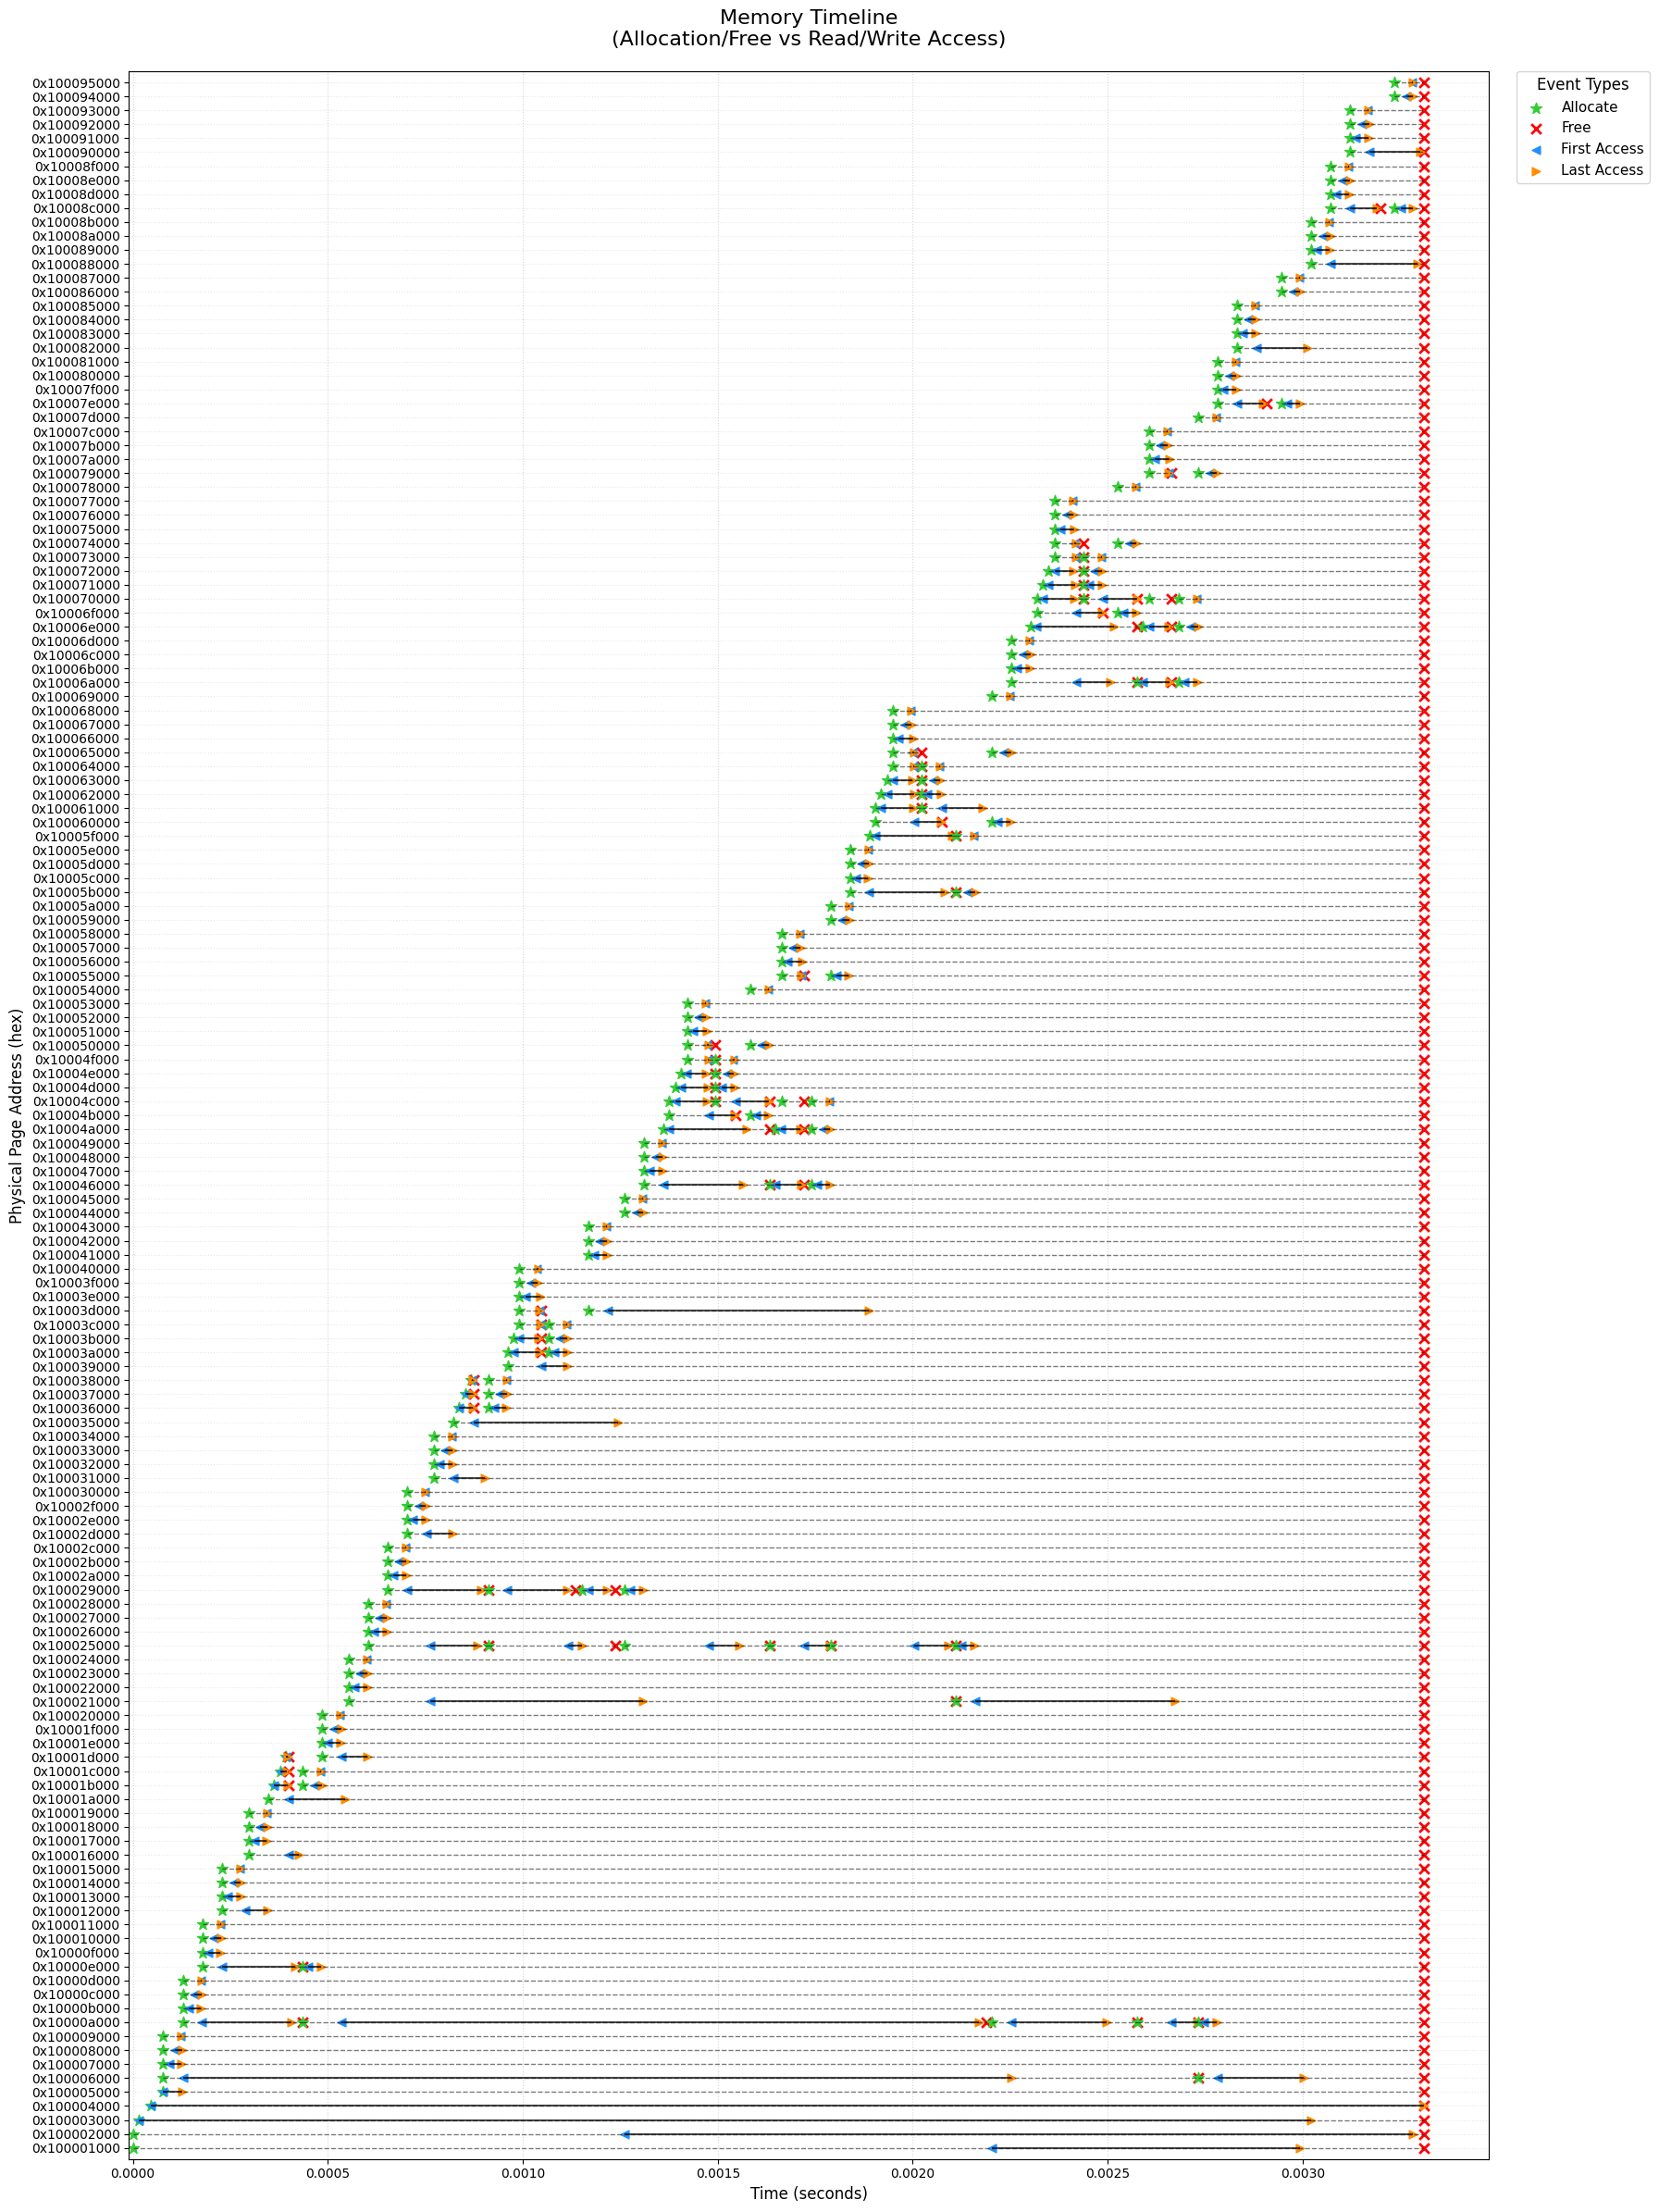

In [366]:
import matplotlib.pyplot as plt
import os

plt.figure(figsize=(18, 24))

# 创建统一的 y 轴映射
all_pages = sorted(lifecycle_df['PageID'].unique())
y_pos_map = {page: i for i, page in enumerate(all_pages)}

# 绘制每段生命周期
for i, row in lifecycle_df.iterrows():
    page = row['PageID']
    y_pos = y_pos_map[page]

    # 分配时间
    plt.scatter(row['AllocateTime'], y_pos,
                color='limegreen', marker='*', s=80,
                label='Allocate' if i == 0 else '')

    # 释放时间
    plt.scatter(row['FreeTime'], y_pos,
                color='red', marker='x', s=60, linewidth=2,
                label='Free' if i == 0 else '')

    # 生命周期虚线
    plt.hlines(y=y_pos,
               xmin=row['AllocateTime'],
               xmax=row['FreeTime'],
               colors='black', linestyles='dashed', alpha=0.5, linewidth=1)

    # 首次访问
    if pd.notnull(row['FirstAccessTime']):
        plt.scatter(row['FirstAccessTime'], y_pos,
                    color='dodgerblue', marker='<', s=40,
                    label='First Access' if i == 0 else '')

    # 最后访问
    if pd.notnull(row['LastAccessTime']):
        plt.scatter(row['LastAccessTime'], y_pos,
                    color='darkorange', marker='>', s=40,
                    label='Last Access' if i == 0 else '')

    # 读写访问时间线
    if pd.notnull(row['FirstAccessTime']) and pd.notnull(row['LastAccessTime']):
        plt.hlines(y=y_pos,
                   xmin=row['FirstAccessTime'],
                   xmax=row['LastAccessTime'],
                   colors='black', alpha=0.7, linewidth=1.5)

# 设置坐标轴标签
plt.yticks(range(len(all_pages)),
           [hex(page * page_size_byte) for page in all_pages],
           fontsize=10)  # 页物理地址
plt.xticks(fontsize=10)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Physical Page Address (hex)', fontsize=12)
plt.title('Memory Timeline\n(Allocation/Free vs Read/Write Access)', fontsize=16, pad=20)

# 计算时间范围
min_time = min(lifecycle_df['AllocateTime'].min(), lifecycle_df['FirstAccessTime'].min(skipna=True))
max_time = max(lifecycle_df['FreeTime'].max(), lifecycle_df['LastAccessTime'].max(skipna=True))
plt.xlim(left=min_time - 0.00001, right=max_time * 1.05)
plt.ylim(bottom=-0.8, top=len(all_pages) - 0.2)

# 添加网格线
plt.grid(True, axis='x', linestyle=':', alpha=0.5)
plt.grid(True, axis='y', linestyle=':', alpha=0.3)

# 图例右侧展示
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),
           bbox_to_anchor=(1.02, 1),
           loc='upper left',
           borderaxespad=0.,
           frameon=True,
           fontsize=11,
           title='Event Types',
           title_fontsize=12)

# 调整布局
plt.subplots_adjust(right=0.85)
plt.tight_layout()

# 保存图像（可指定路径）
results_dir = "./results"
os.makedirs(results_dir, exist_ok=True)
timeline_path = os.path.join(results_dir, 'page_lifecycle_timeline.png')
plt.savefig(timeline_path, dpi=300, bbox_inches='tight')
plt.show()


#### 3. 内存占用

In [367]:
import pandas as pd
from collections import defaultdict

def build_events(df, start_col, end_col):
    """根据起止时间构建事件列表"""
    events = []
    for _, row in df.iterrows():
        start = row[start_col]
        end = row[end_col]
        if pd.notnull(start) and pd.notnull(end):
            events.append((start, 1))   # 开始时 +1
            events.append((end, -1))    # 结束时 -1
    return sorted(events)

def compute_occupancy_and_metrics(events, page_size_byte):
    """计算占用曲线与内存指标"""
    delta_dict = defaultdict(int)
    for time, delta in events:
        if pd.notnull(time):
            delta_dict[time] += delta

    sorted_times = sorted(delta_dict.keys())
    times = []
    usages = []
    current = 0
    for t in sorted_times:
        times.append(t)
        current += delta_dict[t]
        usages.append(current)

    # 最大占用
    max_usage_pages = max(usages, default=0)
    max_usage_bytes = max_usage_pages * page_size_byte

    # 累积占用
    total_usage_pages = 0
    for i in range(len(times) - 1):
        duration = times[i + 1] - times[i]
        height = usages[i]
        total_usage_pages += height * duration
    total_usage_bytes = total_usage_pages * page_size_byte

    return times, usages, max_usage_pages, max_usage_bytes, total_usage_pages, total_usage_bytes

def format_bytes(size_bytes):
    if size_bytes >= 1024**2:
        return f"{size_bytes / 1024**2:.2f} MB"
    elif size_bytes >= 1024:
        return f"{size_bytes / 1024:.2f} KB"
    else:
        return f"{size_bytes:.2f} B"

def report_occupancy_stats(label, max_p, max_b, total_p, total_b):
    print(f"\n///{label}///")
    print(f"最大占用：{max_p} 页 ({format_bytes(max_b)})")
    print(f"累积占用：{total_p:.6f} 页×秒 ({format_bytes(total_b)}·s)")

def run_memory_occupancy_analysis(lifecycle_df, page_size_byte):
    # 分配-释放事件
    alloc_events = build_events(lifecycle_df, 'AllocateTime', 'FreeTime')

    # 访问事件（只保留有效访问）
    valid_access_df = lifecycle_df[
        pd.notnull(lifecycle_df['FirstAccessTime']) & pd.notnull(lifecycle_df['LastAccessTime'])
    ]
    access_events = build_events(valid_access_df, 'FirstAccessTime', 'LastAccessTime')

    # 计算指标
    alloc_stats = compute_occupancy_and_metrics(alloc_events, page_size_byte)
    access_stats = compute_occupancy_and_metrics(access_events, page_size_byte)

    # 输出结果
    alloc_max_p, alloc_max_b, alloc_total_p, alloc_total_b = alloc_stats[2:]
    access_max_p, access_max_b, access_total_p, access_total_b = access_stats[2:]

    report_occupancy_stats("分配-释放", alloc_max_p, alloc_max_b, alloc_total_p, alloc_total_b)
    report_occupancy_stats("首次访问-最后访问", access_max_p, access_max_b, access_total_p, access_total_b)

    print("\n///占用比///")
    print(f"最大占用比（访问/分配）：{access_max_p / alloc_max_p:.2%}" if alloc_max_p > 0 else "N/A")
    print(f"累积占用比（访问/分配）：{access_total_p / alloc_total_p:.2%}" if alloc_total_p > 0 else "N/A")

    return alloc_stats[:2], access_stats[:2]  # 返回时间和占用序列

In [368]:
import matplotlib.pyplot as plt
import os

def plot_occupancy_curves(alloc_data, access_data, results_dir):
    alloc_times, alloc_usage = alloc_data
    access_times, access_usage = access_data

    plt.figure(figsize=(16, 6))
    plt.step(alloc_times, alloc_usage, where='post', label='Allocate-Free Occupancy', color='steelblue', linewidth=2)
    plt.step(access_times, access_usage, where='post', label='Access Occupancy', color='darkorange', linewidth=2, linestyle='--')

    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Memory Occupancy (pages)', fontsize=12)
    plt.title('Memory Occupancy Over Time:\nAllocation vs Access', fontsize=16)
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.legend(fontsize=11)

    os.makedirs(results_dir, exist_ok=True)
    occupancy_compare_path = os.path.join(results_dir, 'memory_occupancy_compare.png')
    plt.savefig(occupancy_compare_path, dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()



///分配-释放///
最大占用：149 页 (596.00 KB)
累积占用：0.275127 页×秒 (1.10 KB·s)

///首次访问-最后访问///
最大占用：14 页 (56.00 KB)
累积占用：0.022820 页×秒 (93.47 B·s)

///占用比///
最大占用比（访问/分配）：9.40%
累积占用比（访问/分配）：8.29%


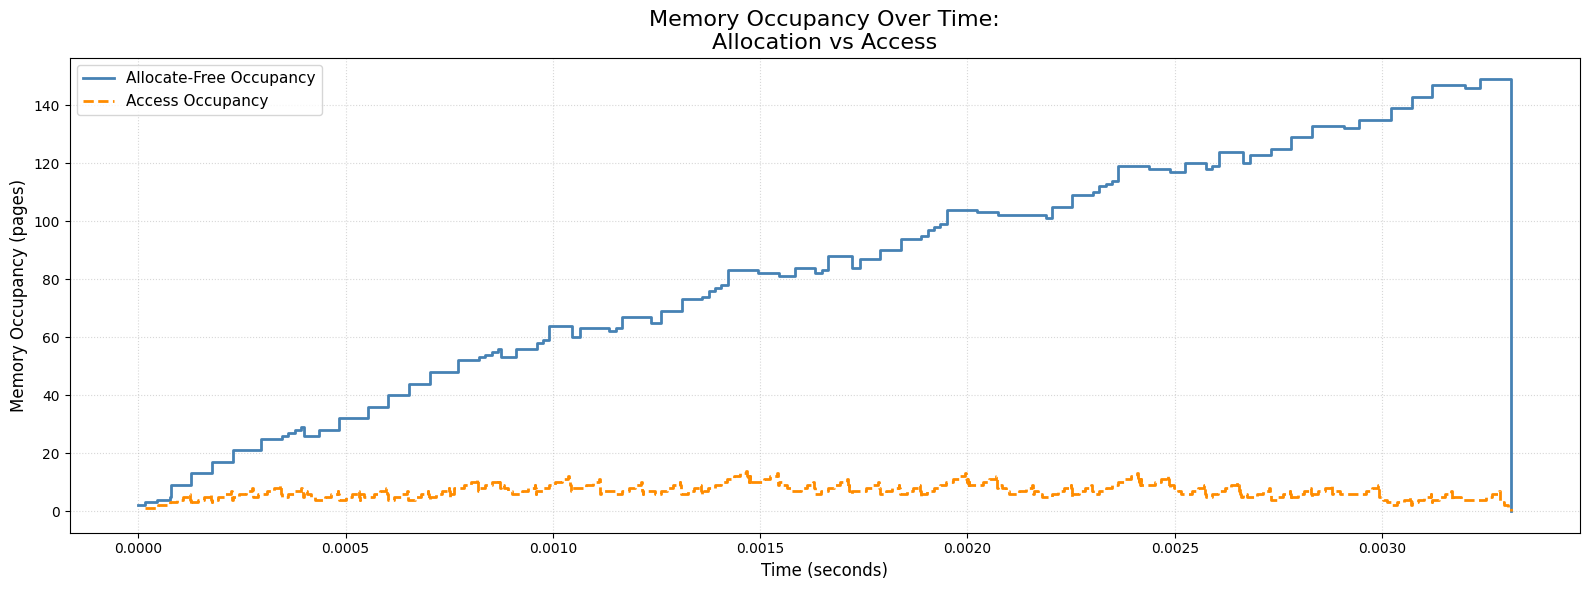

In [369]:
alloc_data, access_data = run_memory_occupancy_analysis(lifecycle_df, page_size_byte)
plot_occupancy_curves(alloc_data, access_data, results_dir)

#### 4. 内存访问

##### 4.1 处理内存访问数据

In [370]:
# 按 PageID 分组，计算各页面的关键时间指标
rw_df = page_access_df[page_access_df['AccessType'].isin(['*mem.ReadReq', '*mem.WriteReq'])]
print(rw_df)

page_rw_stats_df = rw_df.groupby('PageID').agg({
    'StartTime': ['min'],
    "EndTime": ['max'],
    'AccessType': lambda x: list(x.unique())  # 记录所有操作类型
}).reset_index()
page_rw_stats_df.columns = ['PageID', 'FirstAccessTime', 'LastAccessTime', 'AccessTypes']

# 添加生命周期持续时间列
page_rw_stats_df['ActualLifeDuration'] = page_rw_stats_df['LastAccessTime'] - page_rw_stats_df['FirstAccessTime']

print(page_rw_stats_df)

      DeviceID   PageID     AccessType  StartTime   EndTime
1            0  1048577  *mem.WriteReq   0.002203  0.002203
2            0  1048577   *mem.ReadReq   0.002575  0.002575
3            0  1048577  *mem.WriteReq   0.002665  0.002665
4            0  1048577   *mem.ReadReq   0.002731  0.002731
5            0  1048577  *mem.WriteReq   0.002881  0.002882
...        ...      ...            ...        ...       ...
1396         0  1048724  *mem.WriteReq   0.003266  0.003266
1397         0  1048724  *mem.WriteReq   0.003266  0.003266
1398         0  1048724   *mem.ReadReq   0.003283  0.003283
1400         0  1048725  *mem.WriteReq   0.003281  0.003281
1401         0  1048725   *mem.ReadReq   0.003283  0.003283

[1131 rows x 5 columns]
      PageID  FirstAccessTime  LastAccessTime                    AccessTypes  \
0    1048577         0.002203        0.002993  [*mem.WriteReq, *mem.ReadReq]   
1    1048578         0.001260        0.003284  [*mem.WriteReq, *mem.ReadReq]   
2    1048579   

##### 4.2 绘制内存访问图

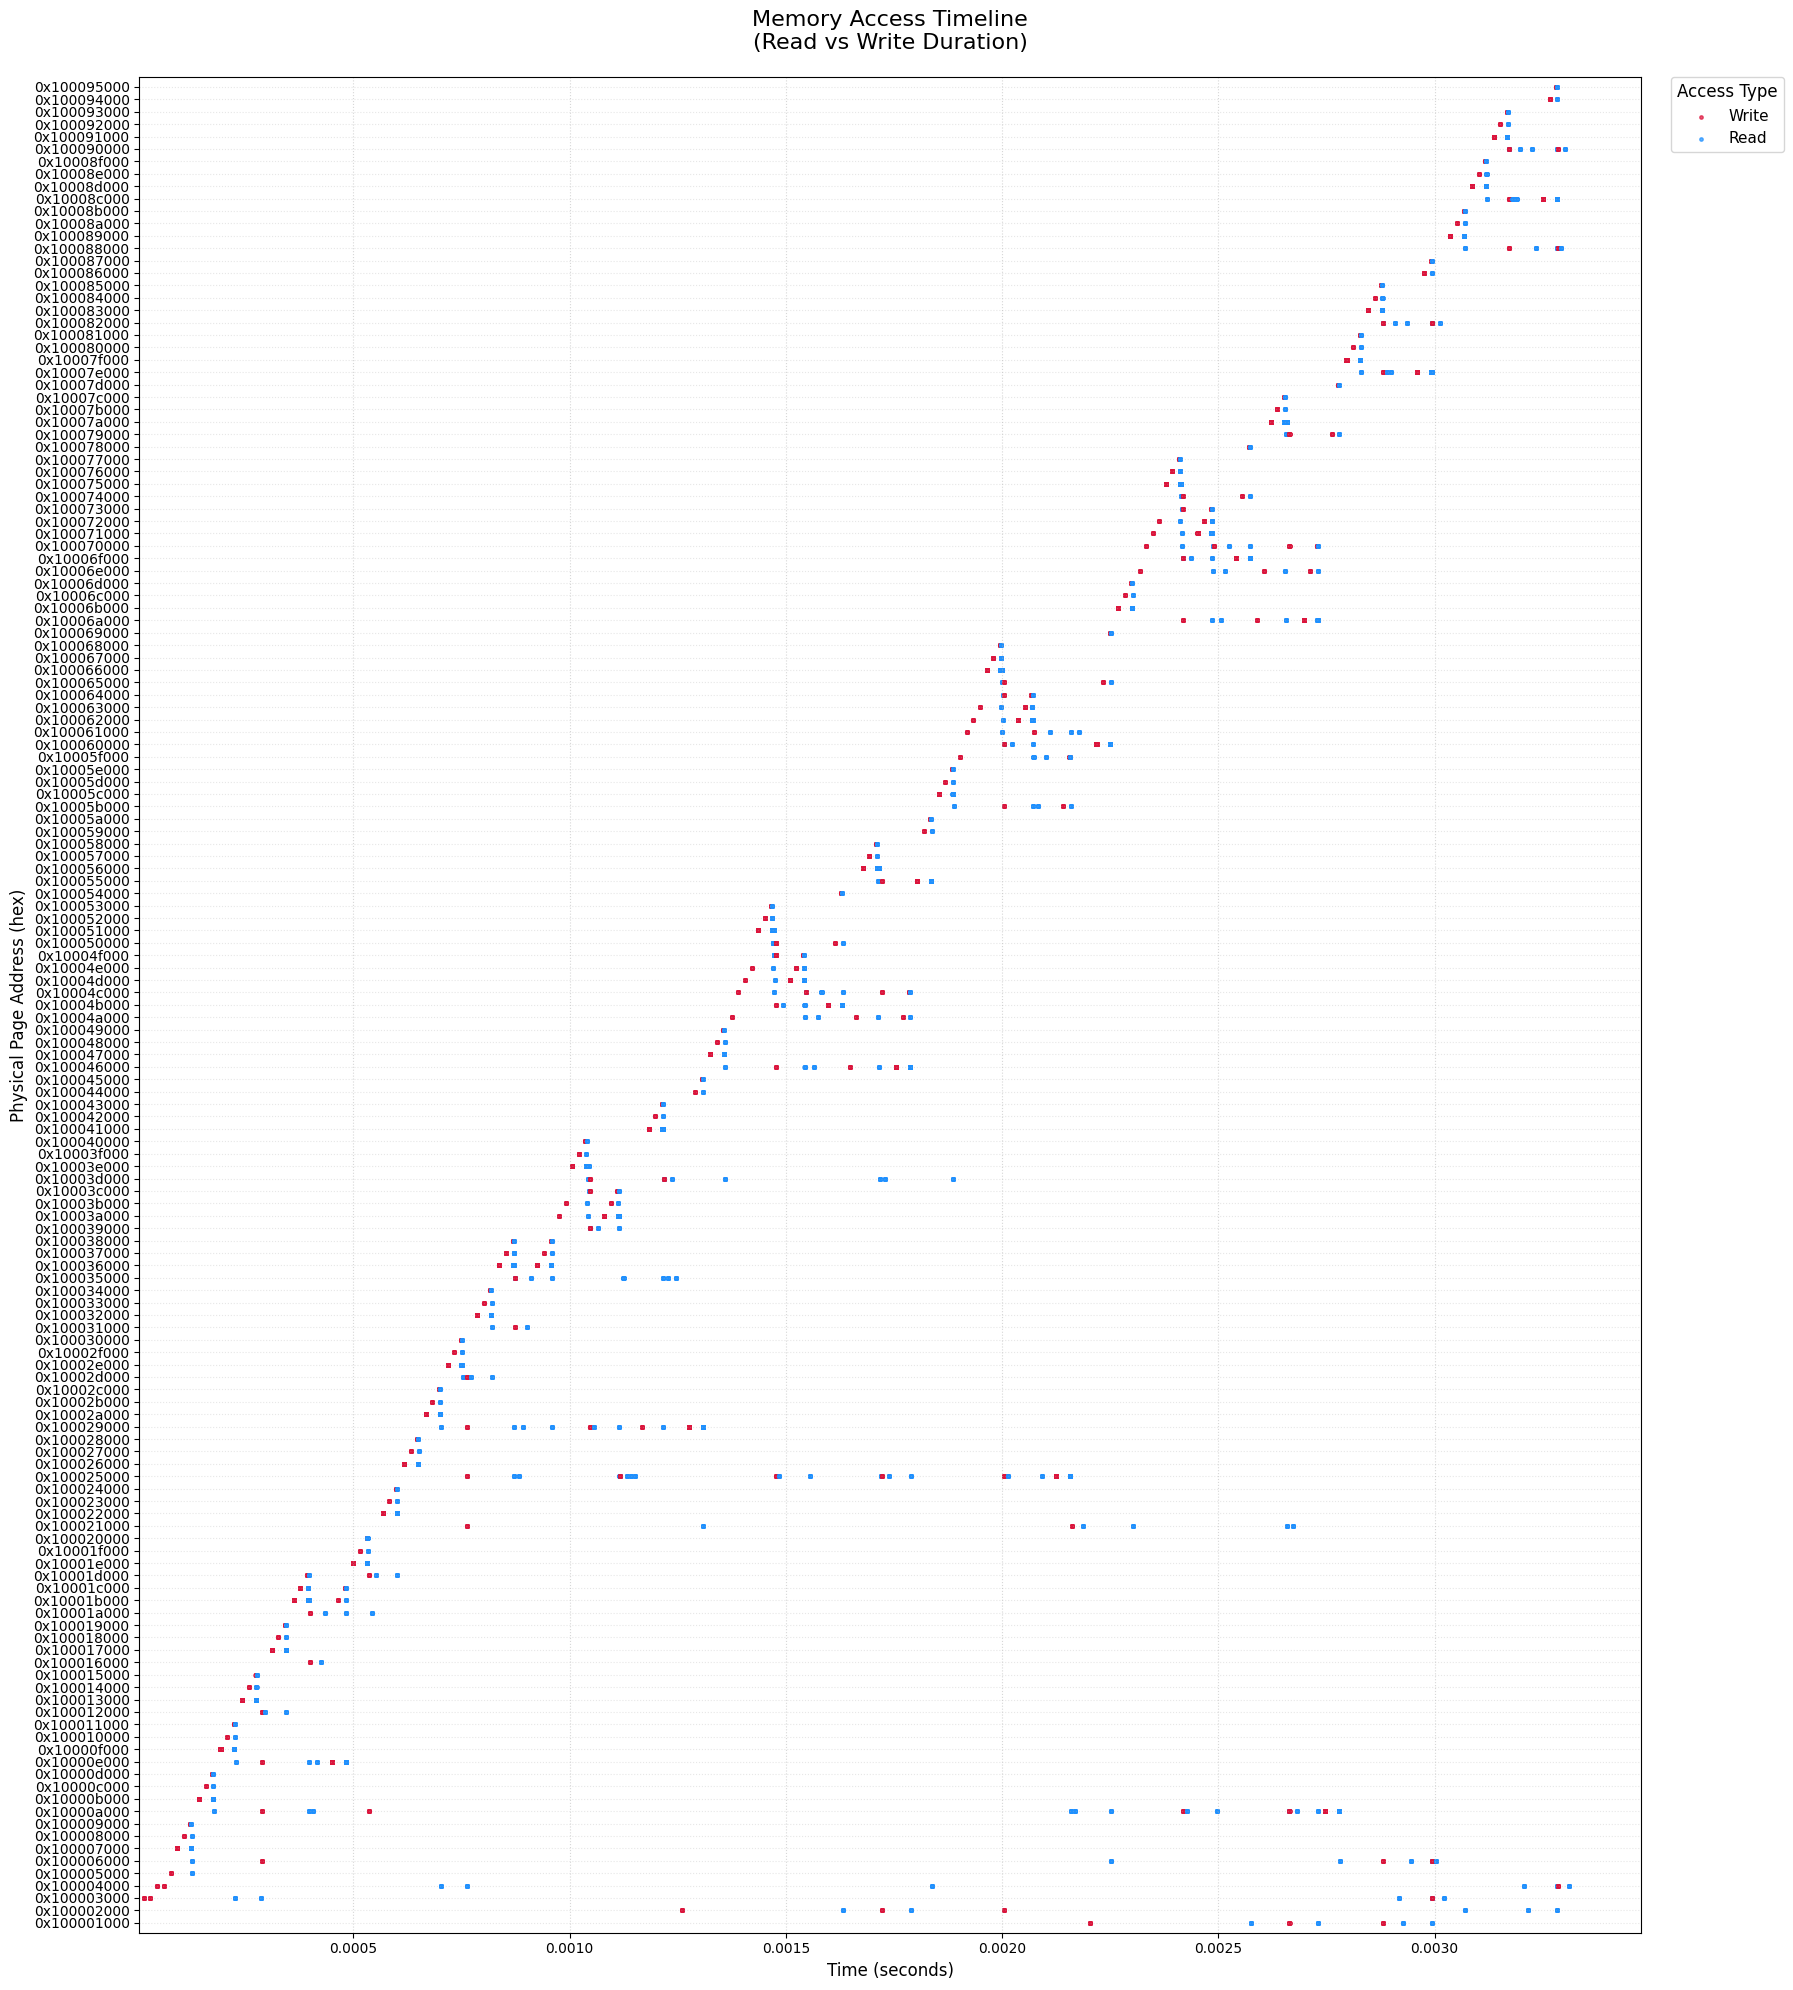

In [371]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 20))

# 创建统一的 y 轴映射（仅基于 rw_df 的 PageID）
all_pages = sorted(rw_df['PageID'].unique())
y_pos_map = {page: i for i, page in enumerate(all_pages)}

# 绘制每个读写访问的持续时间（横线）
for _, row in rw_df.iterrows():
    y_pos = y_pos_map[row['PageID']]
    
    # 根据访问类型选择颜色和样式
    if row['AccessType'] == '*mem.ReadReq':
        color = 'dodgerblue'
        linestyle = '-'  # 实线表示读
        label = 'Read' if _ == 0 or 'Read' not in plt.gca().get_legend_handles_labels()[1] else ''
    else:  # '*mem.WriteReq'
        color = 'crimson'
        linestyle = '--'  # 虚线表示写
        label = 'Write' if _ == 0 or 'Write' not in plt.gca().get_legend_handles_labels()[1] else ''
    
    # 生成在 StartTime 到 EndTime 之间的横向点
    x_points = np.linspace(row['StartTime'], row['EndTime'], num=20)
    y_points = np.full_like(x_points, y_pos)
    
    plt.scatter(
        x_points,
        y_points,
        color=color,
        s=6,           # 控制点的大小
        alpha=0.7,
        label=label
    )

    # 绘制横线（连接 StartTime 和 EndTime）
    # plt.hlines(
    #     y=y_pos,
    #     xmin=row['StartTime'],
    #     xmax=row['EndTime'],
    #     colors=color,
    #     linestyles=linestyle,
    #     alpha=0.7,
    #     linewidth=15,
    #     label=label
    # )
    
    # 可选：在访问的起点和终点添加标记
    # plt.scatter(
    #     row['StartTime'], y_pos,
    #     color=color,
    #     marker='>',  # 右箭头表示开始
    #     s=50,
    #     alpha=0.9,
    #     label=''  # 不重复添加图例
    # )
    # plt.scatter(
    #     row['EndTime'], y_pos,
    #     color=color,
    #     marker='<',  # 左箭头表示结束
    #     s=50,
    #     alpha=0.9,
    #     label=''
    # )

# 设置坐标轴
# plt.yticks(range(len(all_pages)), all_pages, fontsize=10) # y轴显示page id
plt.yticks(range(len(all_pages)), [hex(page * page_size_byte) for page in all_pages], fontsize=10) # y轴显示页物理地址
plt.xticks(fontsize=10)
plt.xlabel('Time (seconds)', fontsize=12)
# plt.ylabel('Page ID', fontsize=12) # y轴显示page id
plt.ylabel('Physical Page Address (hex)', fontsize=12) # y轴显示页物理地址
plt.title('Memory Access Timeline\n(Read vs Write Duration)', fontsize=16, pad=20)

# 调整坐标轴范围
min_time = rw_df['StartTime'].min()
max_time = rw_df['EndTime'].max()
plt.xlim(left=min_time - 0.00001, right=max_time * 1.05)
plt.ylim(bottom=-0.8, top=len(all_pages) - 0.2)

# 添加网格线
plt.grid(True, axis='x', linestyle=':', alpha=0.5)
plt.grid(True, axis='y', linestyle=':', alpha=0.3)

# 自定义图例（避免重复）
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))  # 去重
plt.legend(
    unique_labels.values(),
    unique_labels.keys(),
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.,
    frameon=True,
    fontsize=11,
    title='Access Type',
    title_fontsize=12
)

# 调整布局
plt.subplots_adjust(right=0.85)
plt.tight_layout()

memory_access_path = os.path.join(results_dir, 'memory_access.png')
plt.savefig(memory_access_path, dpi=300, bbox_inches='tight')
plt.show()